In [69]:
import yfinance as yf 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Taken from ARK Fintech Innovation ETF.

In [84]:
start_date = '2023-01-01'
end_date = '2024-12-30'

assets = ['COIN', 'SHOP', 'SQ', 'DKNG', 'PATH', 'ADYEN.AS', 'HOOD', 'GLBE', 'MELI', 'TWLO',
        'TOST', 'INTU', 'ROKU', 'PINS', 'STNE', 'RBLX', 'SOFI', 'DSY.PA', 'PLTR', 'NU',
        'TDOC', 'BILL', 'KSPI', '4689.T', 'AVDX', 'NVDA', 'META', 'CRWD', 'ICE', 'SPOT', 'Z']
assets.sort()

data = yf.download(assets, start = start_date, end = end_date) 
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

data.head()


[*********************100%%**********************]  31 of 31 completed


,4689.T,ADYEN.AS,AVDX,BILL,COIN,CRWD,DKNG,DSY.PA,GLBE,HOOD,...,ROKU,SHOP,SOFI,SPOT,SQ,STNE,TDOC,TOST,TWLO,Z
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02,NaN,1306.400024,NaN,NaN,NaN,NaN,NaN,33.600796,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,NaN,1308.000000,9.24,109.260002,33.599998,103.279999,11.05,33.929092,20.750000,8.08,...,40.560001,35.680000,4.50,81.900002,64.639999,8.47,22.580000,17.549999,50.419998,33.680000
2023-01-04,323.237976,1325.599976,9.46,107.239998,37.700001,104.364998,11.71,34.754814,22.350000,8.36,...,42.349998,37.540001,4.77,81.330002,66.300003,8.76,23.340000,18.420000,52.119999,35.610001
2023-01-05,333.779388,1284.199951,9.21,96.980003,33.529999,94.889999,11.48,34.923935,20.430000,8.11,...,42.759998,35.950001,4.63,81.580002,64.709999,9.01,22.450001,17.280001,50.189999,35.099998
2023-01-06,329.444580,1311.000000,9.29,94.489998,33.259998,94.720001,11.63,34.904037,20.959999,8.25,...,43.599998,36.849998,4.62,83.540001,68.989998,9.29,22.290001,17.430000,50.119999,35.880001


In [71]:
# calculate log normal returns
log_returns = np.log(data / data.shift(1))
log_returns.dropna(inplace=True)
log_returns.head()

,4689.T,ADYEN.AS,AVDX,BILL,COIN,CRWD,DKNG,DSY.PA,GLBE,HOOD,...,ROKU,SHOP,SOFI,SPOT,SQ,STNE,TDOC,TOST,TWLO,Z
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-22,-0.000417,0.021533,0.035091,0.035500,0.027358,0.027565,0.008470,0.021119,0.014046,0.025808,...,0.015838,0.003120,0.055822,0.004679,0.012676,0.017463,0.034000,-0.007525,0.007605,0.020743
2024-01-23,0.006851,0.006043,0.006332,-0.002533,-0.031857,-0.004665,0.009183,-0.003826,-0.015381,-0.003646,...,0.027979,0.010905,-0.021698,0.005044,-0.007375,-0.014531,-0.009597,-0.012277,-0.001625,-0.012321
2024-01-24,-0.006227,0.018590,-0.016364,-0.023769,-0.023216,0.010075,0.004430,0.011224,-0.008858,-0.012868,...,-0.030583,-0.005066,-0.024822,0.021205,-0.056394,0.016836,-0.026877,-0.042662,-0.013643,-0.009342
2024-01-25,-0.017008,-0.030888,0.000000,0.010874,-0.002723,-0.022974,0.005962,0.005670,0.005646,-0.010228,...,0.006777,-0.002977,0.011834,0.014295,0.002235,0.030056,0.007893,0.018851,-0.004129,0.013708
2024-01-26,-0.009148,0.011609,0.009124,0.005527,0.034039,-0.010792,-0.005443,0.001046,0.038137,0.008376,...,0.001912,0.013083,-0.003929,0.000513,0.035405,0.011111,-0.006903,0.049937,-0.008171,0.026157


In [72]:
# calculate the covariance matrix for annualized returns 
cov_matrix = log_returns.cov() * 252 

In [73]:
# calculate standard deviation
def standard_deviation(weights, cov_matrix):
    var = weights.T @ cov_matrix @ weights
    return np.sqrt(var)

# calculate expected returns (based off historical returns)
def portfolio_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

# calculate sharpe ratio
def sharpe_ratio(weights, log_returns, cov_matrix):
    ret = portfolio_return(weights, log_returns)
    std = standard_deviation(weights, cov_matrix)
    return (ret - 0.02) / std   # 2% risk free rate assumption

# required for minimize function
def neg_sharpe_ratio(weights, log_returns, cov_matrix):
    return -sharpe_ratio(weights, log_returns, cov_matrix)

In [74]:
# set bounds and constraints
bounds = [(0, 0.5) for i in range(len(assets))]
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

In [75]:
# initial weights (equal weighted)
initial_weights = np.array([1/len(assets)]* len(assets))
print(initial_weights)

[0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806]


In [76]:
# find optimized results
optimized = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

# set optimal weights
optimized_portfolio = optimized.x

In [80]:
print("Optimized Portfolio Weights") 
data = {'Asset': assets, 'Weight (%)': [round(weight*100, 2) for weight in optimized_portfolio]}

# Create a DataFrame
portfolio_df = pd.DataFrame(data)
portfolio_df = portfolio_df.sort_values(by='Weight (%)', ascending=False)
optimal_portfolio_return = portfolio_return(optimized_portfolio, log_returns)
optimal_portfolio_volatility = standard_deviation(optimized_portfolio, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimized_portfolio, log_returns, cov_matrix)

print(portfolio_df.head(10))
print(optimal_portfolio_return)
print(optimal_portfolio_volatility)
print(optimal_sharpe_ratio)

Optimized Portfolio Weights
       Asset  Weight (%)
24      SPOT       26.83
1   ADYEN.AS       14.15
16      NVDA       12.99
6       DKNG       11.90
12      KSPI       11.53
2       AVDX        9.67
9       HOOD        8.44
15        NU        4.51
25        SQ        0.00
19      PLTR        0.00
1.821424995094799
0.2097474972337868
8.588541073683999


## Plot the Optimized Portfolio Results

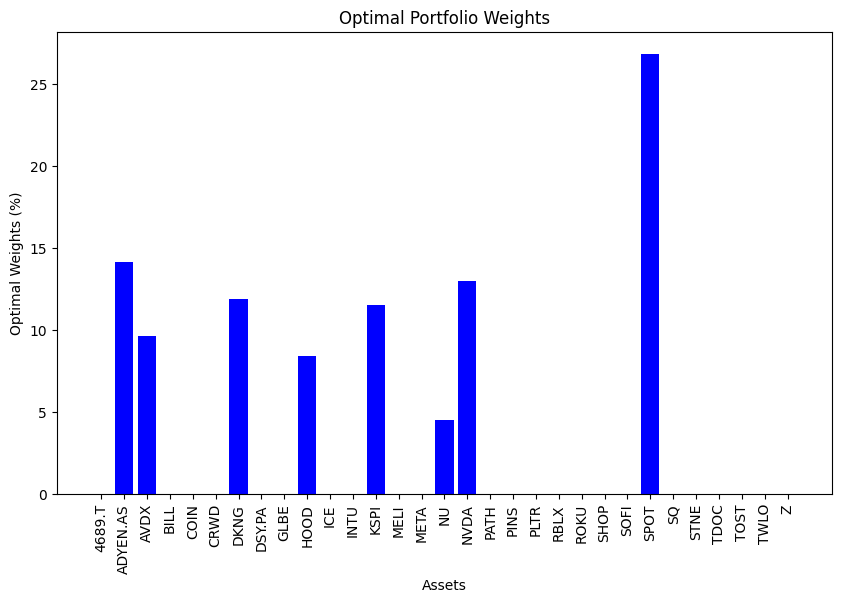

In [86]:
plt.figure(figsize=(10, 6))
plt.bar(assets, optimized_portfolio * 100, color='blue')

plt.xlabel('Assets')
plt.ylabel('Optimal Weights (%)')
plt.title('Optimal Portfolio Weights')
plt.xticks(rotation=90)

plt.show()